There is a chance that previous attempts at kernel density estimation were hindered by the high-dimensional aspects of the data set. That is, due to accumulation of small changes in each dimension, the points may give poor coverage of the sample space. We can address this possibly by selecting only a few features to look at, or a tranformation of the data set. Here are a few options which spring to mind:

 - use principal component analysis, factor analysis, or some other correlation-based method to pick a linear subspace
 - use a randomized projection method to pick a linear subspace
 - pick factors based on how well they separate the hazards from the non-hazards
 
For now, I will look at this last one. I will select a few features based on the normalized within-ss score, which measures how much the variance of a data set is reduced by partitioning it in two. Any partitioning of the data set will reduce its variance, but if the partitioning explains more than about 65% of the variance that indicates a notable improvement.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import git
import os
import sys
root = git.Repo(os.getcwd(), search_parent_directories=True).git.rev_parse("--show-toplevel")
sys.path.append(os.path.join(root, 'data_processing'))

from make_features import load_data, make_undirected

In [2]:
incidents, acceleration = load_data()
features = make_undirected(acceleration)

In [11]:
X = features
y = incidents['motion'] != 'other'

In [13]:
withinss = (X[y].var(ddof=0)*y.mean() + X[~y].var(ddof=0)*(~y).mean())/X.var(ddof=0)
withinss

beginning maximum                     0.996298
beginning minimum                     0.998666
beginning range                       0.996442
beginning mean                        0.998520
beginning standard deviation          0.998358
beginning variance                    0.999046
beginning skew                        0.997987
beginning kurtosis                    0.997809
beginning total variation             0.998474
beginning angular path length         0.997472
beginning biggest angle difference    0.998207
beginning low frequency power         0.999890
beginning medium frequency power      0.999982
beginning high frequency power        0.999979
middle maximum                        0.999960
middle minimum                        0.999791
middle range                          0.999834
middle mean                           0.999898
middle standard deviation             0.999832
middle variance                       0.999940
middle skew                           0.999677
middle kurtos

We can see that the withinss is nowhere near the 35% we would hope for, which would indicate a relly good split in the data. Perhaps there is still something to be gained here, though. Let's plot the two best-scoring features against one another.

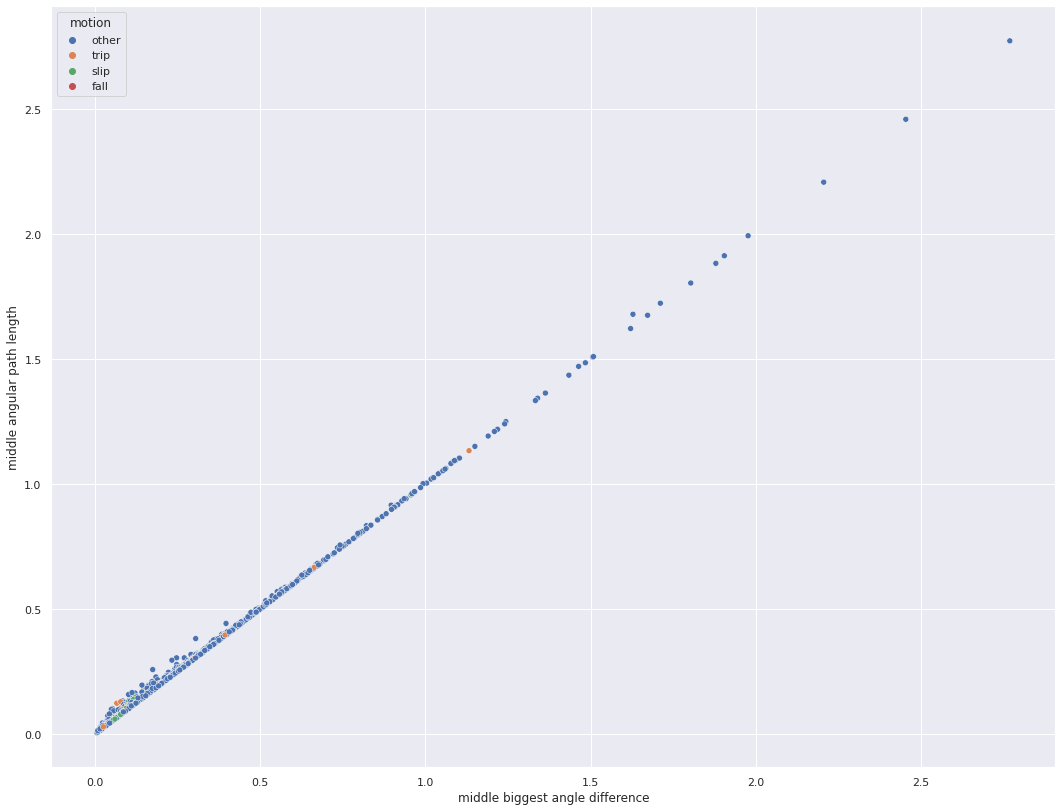

In [37]:
best_features = withinss.sort_values().index

plt.figure(figsize=(18,14))
sns.scatterplot(data=features, x=best_features[0], y=best_features[1], hue=incidents['motion'], hue_order=['other','trip','slip', 'fall'])
plt.show()

Those features are very well correlated, so let's try the next one down the list:

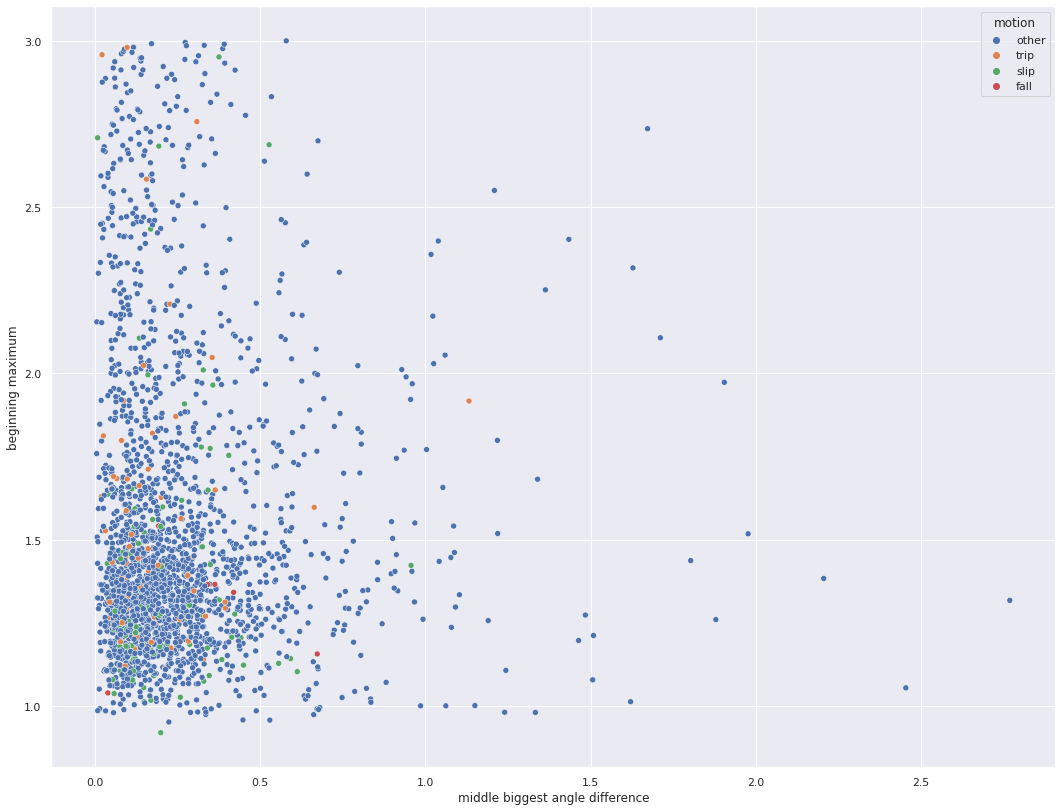

In [38]:
plt.figure(figsize=(18,14))
sns.scatterplot(data=features, x=best_features[0], y=best_features[2], hue=incidents['motion'], hue_order=['other','trip','slip', 'fall'])
plt.show()

Let's see that with hulls:

In [39]:
from scipy.spatial import ConvexHull
def hull_plot(data, x, y):
    columns = data[[x, y]]
    plt.gca().set_prop_cycle(None)
    for motion in ['other','trip','slip', 'fall']:
        subset = columns[incidents['motion'] == motion]
        if len(subset) >= 3:
            points = subset.values
            hull = ConvexHull(points)
            xx = points[hull.vertices][:, 0]
            yy = points[hull.vertices][:, 1]
        else:
            # plot something to advance the color counter
            xx = np.zeros(0)
            yy = np.zeros(0)
        plt.fill(xx, yy, alpha=0.3)
    
    sns.scatterplot(data=data, x = x, y=y, hue=incidents['motion'], hue_order=['other','trip','slip', 'fall'],)

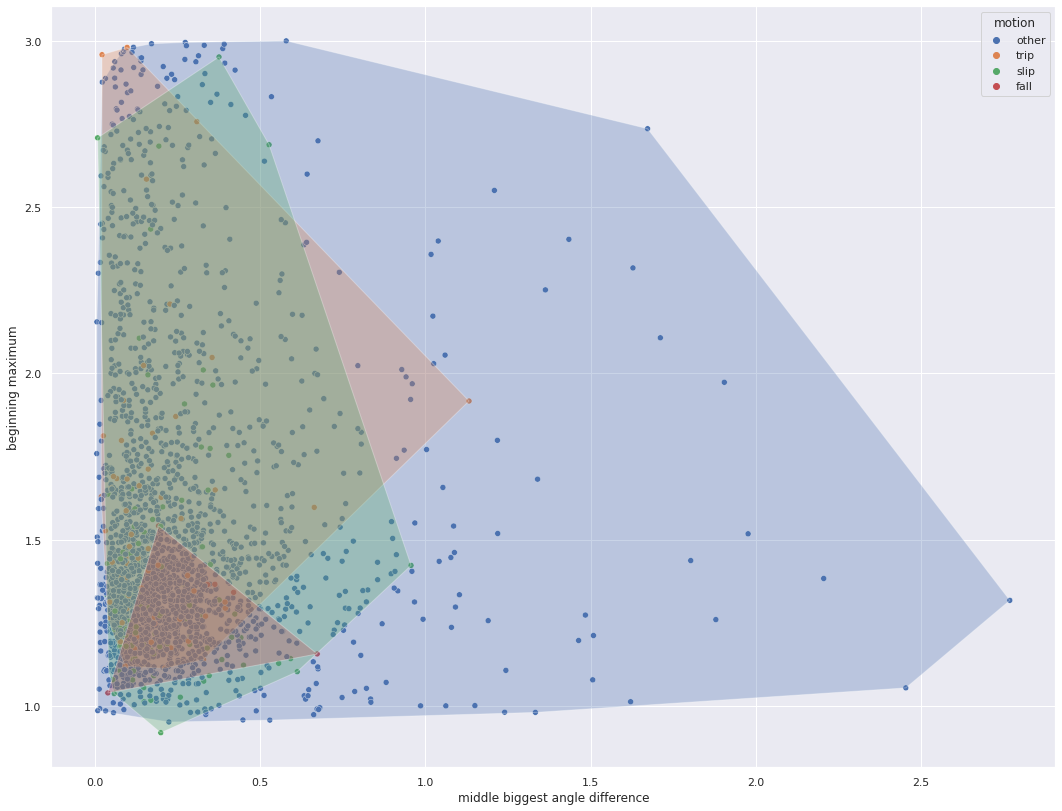

In [40]:
plt.figure(figsize=(18,14))
hull_plot(data=features, x=best_features[0], y=best_features[2])
plt.show()

That looks pretty good, actually! Let's see a few more.

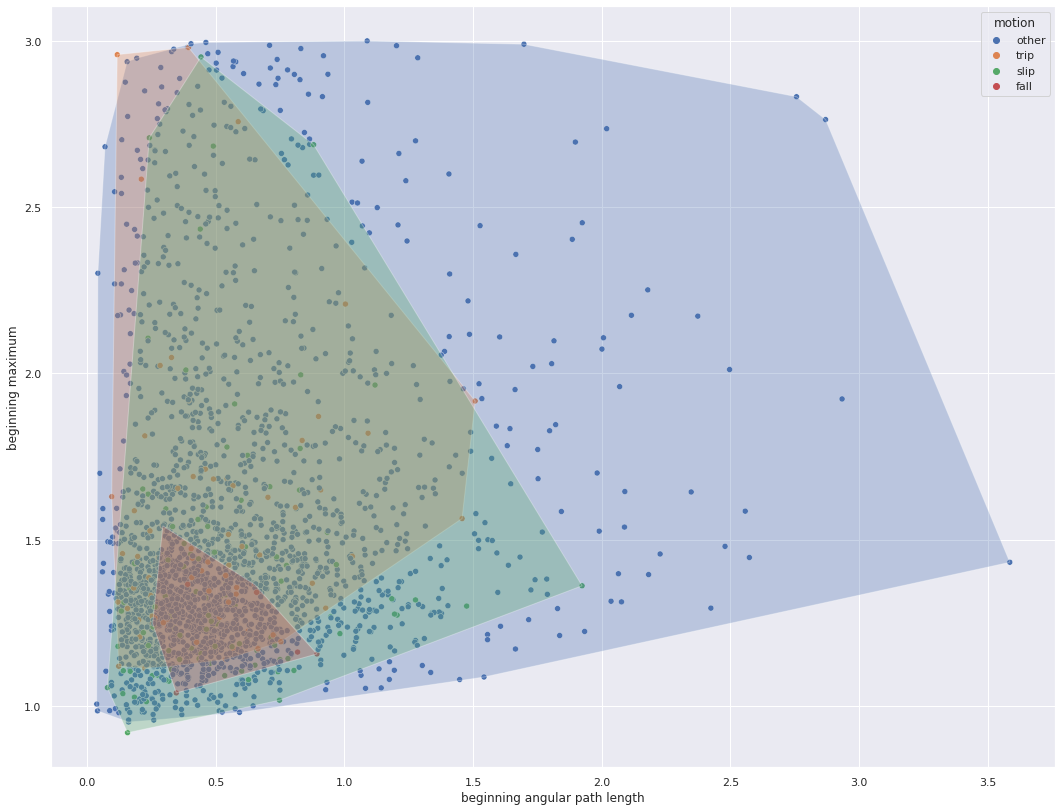

In [44]:
plt.figure(figsize=(18,14))
hull_plot(data=features, x=best_features[4], y=best_features[2])
plt.show()

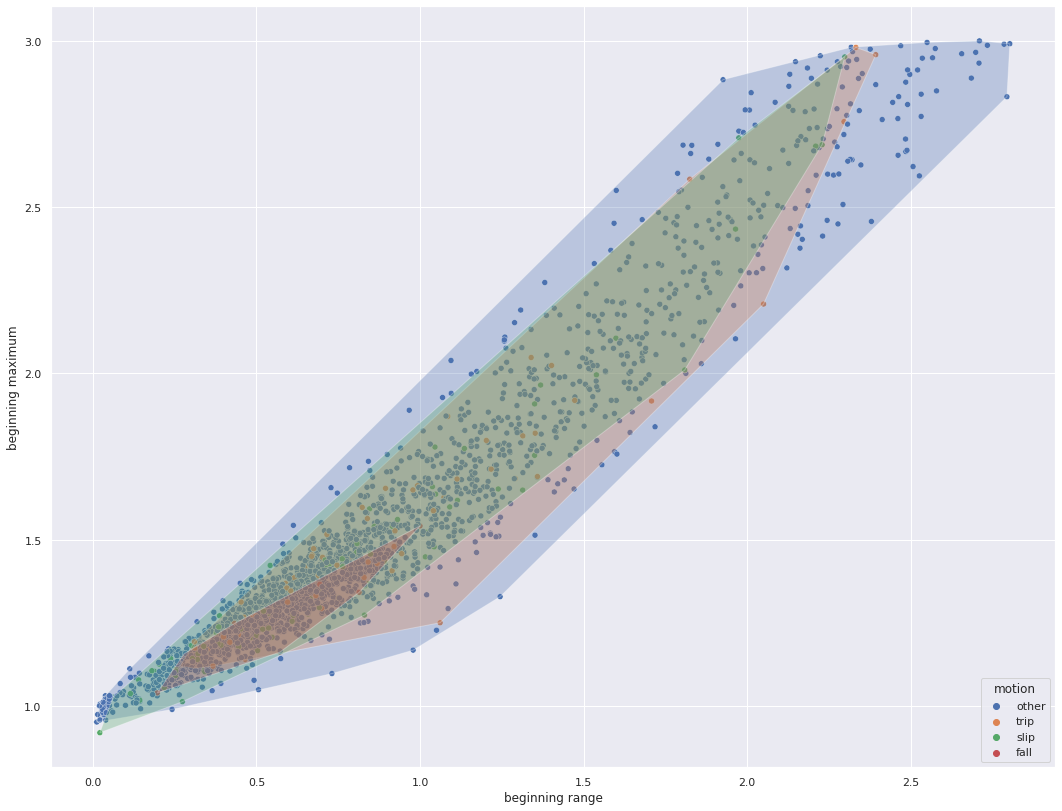

In [54]:
plt.figure(figsize=(18,14))
hull_plot(data=features, x=best_features[3], y=best_features[2])
plt.show()

Let's take the top five features and repeat the aggregate risk assessment.

In [55]:
X = features[best_features[:5]]

In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [57]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV


params = {"bandwidth": np.logspace(-1, 0, 50)}
grid = GridSearchCV(KernelDensity(), params)

grid.fit(X[y])
print("best bandwidth for hazards: {0}".format(grid.best_estimator_.bandwidth))
hazard_kde = grid.best_estimator_

grid = GridSearchCV(KernelDensity(), params)
grid.fit(X[~y])
print("best bandwidth for typicals: {0}".format(grid.best_estimator_.bandwidth))
typical_kde = grid.best_estimator_

best bandwidth for hazards: 0.29470517025518106
best bandwidth for typicals: 0.22229964825261944


# the likelihoods we see

Applying these density estimates, we can get an idea for the typical values of our estimators. Note that these give the log of the probability density, not the probability density directly. By 

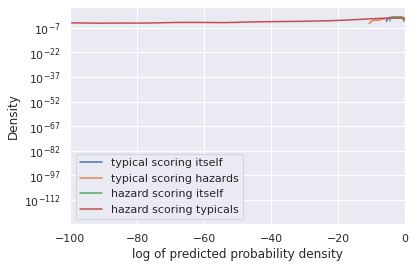

In [58]:
sns.kdeplot((typical_kde.score_samples(X[~y])), label="typical scoring itself")
sns.kdeplot((typical_kde.score_samples(X[y])), label="typical scoring hazards")
sns.kdeplot((hazard_kde.score_samples(X[y])), label="hazard scoring itself")
sns.kdeplot((hazard_kde.score_samples(X[~y])), label="hazard scoring typicals")
plt.legend()
plt.yscale('log')
plt.xlim(-100, 0)
plt.xlabel('log of predicted probability density')
plt.show()

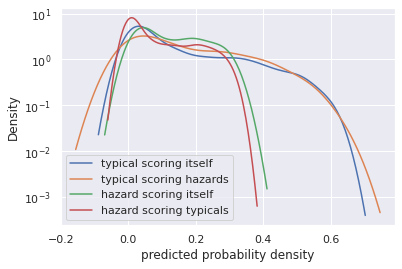

In [59]:
sns.kdeplot(np.exp(typical_kde.score_samples(X[~y])), label="typical scoring itself")
sns.kdeplot(np.exp(typical_kde.score_samples(X[y])), label="typical scoring hazards")
sns.kdeplot(np.exp(hazard_kde.score_samples(X[y])), label="hazard scoring itself")
sns.kdeplot(np.exp(hazard_kde.score_samples(X[~y])), label="hazard scoring typicals")
plt.legend()
plt.yscale('log')
plt.xlabel('predicted probability density')
plt.show()

In [60]:
peak_value = (2*np.pi)**(-X.shape[1]/2)
display(peak_value)
display(np.log(peak_value))

0.010105326013811644

-4.594692666023364

# the classifier

We will apply the strategy above to the validation data we were provided. We will create a text-based summary, and a visualization of the decision regions.

In [61]:
validation_incidents, validation_acceleration = load_data(test_data=True)
validation_features = make_undirected(validation_acceleration)

In [65]:
X_test = validation_features[best_features[:5]]
y_test = (validation_incidents['motion'] != 'other')
X_test = scaler.transform(X_test)

In [66]:
typical_prob = np.exp(typical_kde.score_samples(X_test))
hazard_prob = np.exp(hazard_kde.score_samples(X_test))
unseen_prob = (2*np.pi)**(-X_test.shape[1]/2) * np.exp((X_test**2).sum(axis=1)/2)

In [68]:
from ipywidgets import interact
import ipywidgets as widgets

@interact
def proprtional_table(
    base_rate = widgets.FloatSlider(value=y.mean(), min=0, max=1, step=0.01, readout_format='.2f'), 
    temperance = widgets.FloatSlider(value=0.8, min=0, max=1, step=0.01, readout_format='.2f')
):
    unseen_weighted = unseen_prob*temperance
    hazard_weighted = hazard_prob*(1-temperance)*base_rate
    typical_weighted = typical_prob*(1-temperance)*(1-base_rate)

    clf = np.zeros_like(y_test, dtype=int)
    clf[unseen_weighted > hazard_weighted + typical_weighted] = -1
    clf[hazard_weighted > typical_weighted] = 1

    counts = (pd.DataFrame(
            {'hazards':pd.value_counts(clf[y_test]), 'typicals': pd.value_counts(clf[~y_test])}
            , index=[-1, 0, 1]
        ).fillna(0)
        .astype(int)
        .rename({-1: 'undecided', 0:'typical', 1:'hazard'})
    )
    counts.index.name = 'prediction'
    print(f'ppv: {counts.iloc[2, 0] / (1+counts.iloc[2, :].sum())}')
    return counts

interactive(children=(FloatSlider(value=0.08340611353711791, description='base_rate', max=1.0, step=0.01), Flo…

Not doing great. We can get a PPV of almost 40% by turnign the base rate up and keeping the temperance high, but still not what I would want from a classifyer. This might meet our criteria for a risk-quantifyer, though. Plus, I think this does a good job of illustrating why our classifyers have done so poorly: the high-risk incidents are generally in the middle of the pack.